In [24]:
import sys
sys.path.append('../prototypical_networks_with_autoencoders/')

import os
import math
import pickle
import random
from functools import partial
from typing import Dict, Optional, Callable
from datetime import datetime

# for math operations
import gdown
import numpy as np
from tqdm import tqdm

# ML packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

# training visualization
# from tqdm import trange
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter

import learn2learn as l2l
from learn2learn.data.transforms import NWays, KShots, LoadData, RemapLabels

# impelementations
from prototypical_network import ClassificationDataset, PrototypicalNetwork, Convnet
from generative_adversarial import GANSupervisor, Discriminator, Generator


state = 42
torch.manual_seed(state)
torch.cuda.manual_seed(state)
np.random.seed(state)
random.seed(state)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

# Dataset

In [26]:
def log(*args, file_path: str=''):
    now = datetime.now()
    # open the file in append mode
    with open(file_path+"log.txt", 'a') as f:
        # write to the file
        f.write(f'[{now.strftime("%d/%m/%Y %H:%M:%S")}]{" ".join(map(str,args))}\n')
    
    print(f'[{now.strftime("%d/%m/%Y %H:%M:%S")}]{" ".join(map(str,args))}')

def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)

def get_bird_dataset(path: str= "../../datasets/birds/",
                        mode: str= "train") -> torch.utils.data.Dataset:
    
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize((96,96)),
         # transforms.Normalize((0.5), (0.5))
        ])

    # transform = transforms.ToTensor()

    dataset = datasets.ImageFolder(path+f'/{mode}/',
                                        transform=transform)
    
    return dataset
    
def get_mini_imagenet_dataset(path: str= "../../datasets/mini_imagenet/",
                        mode: str= "train") -> torch.utils.data.Dataset:
    
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize((96,96), antialias=True),
         transforms.Normalize((0.5), (0.5))
        ])

    # transform = transforms.ToTensor()

    dataset = datasets.ImageFolder(path+f'/{mode}/',
                                        transform=transform)
    dataset.y = [64] if mode == "train" else [20] if mode == "test" else [16]
    return dataset

def get_tiered_imagenet_dataset(path: str= "../../datasets/tiered_imagenet/",
                        mode: str= "train") -> torch.utils.data.Dataset:
    
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize((96,96), antialias=True),
         transforms.Normalize((0.5), (0.5))
        ])

    # transform = transforms.ToTensor()

    dataset = datasets.ImageFolder(path+f'/{mode}/',
                                        transform=transform)
    dataset.y = [351] if mode == "train" else [160] if mode == "test" else [97]
    return dataset

def get_fc100_dataset(path: str= "../../datasets/FC100/",
                        mode: str= "train") -> torch.utils.data.Dataset:
    
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize((96,96), antialias=True),
         transforms.Normalize((0.5), (0.5))
        ])

    # transform = transforms.ToTensor()

    dataset = datasets.ImageFolder(path+f'/{mode}/',
                                        transform=transform)
    dataset.y = [60] if mode == "train" else [20] if mode == "test" else [20]
    return dataset

def check_folder_loader(dataset: torch.utils.data.Dataset, grid_split: int= 10, num_img: int= 30) -> None:
    label_mapping = {y: x for x, y in dataset.class_to_idx.items()}

    fraction = math.ceil(num_img/grid_split)
    width = grid_split if fraction != 0 else num_img
    height = fraction if  width == grid_split else 1

    figure = plt.figure(figsize=(width, height))
    for i, (img, label) in enumerate(dataset):
        if i==0: print(f"image.shape: {img.shape}")
        elif i>=num_img: break
        
        figure.add_subplot(height, width, i+1)
        plt.title(label_mapping[label], fontsize=4)
        plt.axis("off")
        plt.imshow(img[0].numpy(), cmap="gray")
        

def check_MetaDataset_loader(dataset: torch.utils.data.Dataset, grid_split: int= 10, num_img: int= 30) -> None:
    sample = dataset.sample()
    fraction = math.ceil(num_img/grid_split)
    width = grid_split if fraction != 0 else num_img
    height = fraction if  width == grid_split else 1

    figure = plt.figure(figsize=(width, height))
    for i, img in enumerate(sample[0]):
        if i==0: print(f"image.shape: {img.shape}")
        elif i>=num_img: break
        
        figure.add_subplot(height, width, i+1)
        plt.title(sample[1][i].numpy(), fontsize=4)
        plt.axis("off")
        plt.imshow(img[0].numpy(), cmap="gray")

image.shape: torch.Size([3, 96, 96])


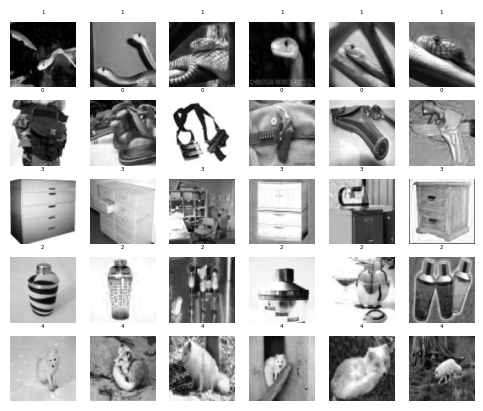

In [9]:
transform = transforms.Compose([
    transforms.Resize((96,96)),
    ])

dataset = get_mini_imagenet_dataset(path="../../datasets/mini_imagenet/", mode= "train")

mode_dataset = l2l.data.MetaDataset(dataset)
mode_transforms = [
    NWays(mode_dataset, 5),
    KShots(mode_dataset, 1+5),
    LoadData(mode_dataset),
    RemapLabels(mode_dataset),
]

mode_tasks = l2l.data.TaskDataset(mode_dataset, task_transforms=mode_transforms,
                                  num_tasks= max(dataset.y))

mode_loader = DataLoader(mode_tasks, pin_memory=True, shuffle=True, )
check_MetaDataset_loader(dataset= mode_loader.dataset, grid_split= 6, num_img= 50)

# Prototypical Network With GAN

In [28]:
class GANPrototypicalNetwork(PrototypicalNetwork):
    
    def __init__(self, encoder: nn.Module, gan_supervisor: GANSupervisor):
        super(GANPrototypicalNetwork, self).__init__()
        self.gan_supervisor = gan_supervisor
        self.encoder = encoder
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.update = False

    def forward(self, support_set, support_classes, query_set, ways, shot, query_num, metric=None, device=None) -> torch.Tensor:
        if metric is None:
            metric = PrototypicalNetwork.pairwise_distances_logits
        if device is None:
            device = self.device
        
        support_embeddings = torch.flatten(self.encoder(support_set), start_dim=1)
        query_embeddings = torch.flatten(self.encoder(query_set), start_dim=1)
        
        # print(f"support_embeddings:{support_embeddings.shape}, query_embeddings:{query_embeddings.shape}")
        centriods = support_embeddings.reshape(ways, shot, -1).mean(dim=1)

        logits = metric(query_embeddings, centriods)
        
        return logits

    def gan_update(self, data):
        X = data.to(self.device)
        # print(X.shape)
        transform = transforms.Compose([
            transforms.Resize((64,64)),
            ])

        D_loss, real_loss, fake_loss = self.gan_supervisor.train_discriminator(transform(X))
        G_loss = self.gan_supervisor.train_generator(transform(X))


    
    def eval_model(self, way, shot, query, num_episode, data_loader, optimizer, metric, criterion: nn.modules.loss, device, mode, output_path, epoch=None):
        n_loss = []
        n_acc = []
        self.gan_supervisor.criterion = nn.BCELoss() 
        with tqdm(range(num_episode), unit="episode") as tepoch:
            if epoch != None: tepoch.set_description(f"Epoch {epoch}")
            for i in tepoch:
                batch = GANPrototypicalNetwork.extract_sample(data_loader= data_loader, ways= way,
                                                           shot= shot, query_num=query, device=device)
                support_set, support_classes, query_set, query_classes = batch

                remap_support_set, remap_support_classes, support_mapping = PrototypicalNetwork.set_consecutive_labels(support_set, support_classes)
                remap_query_set, remap_query_classes, query_mapping = PrototypicalNetwork.set_consecutive_labels(query_set, query_classes)

                # print(f'support_set:{support_set.shape}, support_classes:{support_classes.shape}, query_set:{query_set.shape}, query_classes:{query_set.shape}')
                if mode == "train" or self.update: self.gan_update(support_set)

                logits = self.forward(support_set= remap_support_set, support_classes= remap_support_classes, query_set=remap_query_set,
                                       ways=way, shot= shot, query_num= query, metric=metric, device=device)
                
                
                loss = criterion(logits, remap_query_classes.long())
                acc = GANPrototypicalNetwork.accuracy(logits, remap_query_classes.long())

                n_loss.append(loss.item())
                n_acc.append(acc)
                
                tepoch.set_postfix(mode=mode,  loss=f"({round(np.mean(n_loss), 4):.4f}, {round(np.var(n_loss), 4):.4f})",
                                   acc=f"({np.round(np.mean(n_acc),decimals = 3):.3f}, {np.round(np.var(n_acc),decimals = 3):.3f})")
                
                if mode == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                else:
                    self.hist[f"{mode}_labels"].extend([query_mapping[int(x)] for x in remap_query_classes])
                    self.hist[f"{mode}_logits"].extend([query_mapping[int(x)] for x in np.argmax(logits.cpu().detach().numpy(), axis=1)])
            log(f'{f"[Epoch {epoch}]"if epoch!=None else ""}[{mode}]: acc= ({np.round(np.mean(n_acc),decimals = 3):.3f}, {np.round(1.96*np.std(n_acc)/len(n_acc),decimals = 3):.3f}), loss= ({round(np.mean(n_loss), 4):.4f}, {round(1.96*np.std(n_loss)/len(n_loss), 4):.4f})', file_path=output_path)
            if mode != "train": self.save_best_model(n_acc, n_loss, output_path, epoch)
                    
    def fit(self, train_way: int, train_shot: int, train_query: int, train_num_episode: int,
            test_way: int, test_shot: int, test_query: int, test_num_episode: int, epochs:int, get_dataset: Callable,
            eval_step:int, early_stop:bool, optimizer: torch.optim, lr_scheduler, loss: nn.modules.loss, output_path,) -> None:
            
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        
        train_loader = self.data_loader(dataset= get_dataset(mode= 'train'),
                                        way= train_way, shot= train_shot, query= train_query, mode='train')
        val_loader = self.data_loader(dataset= get_dataset(mode= 'val'),
                                      way= test_way, shot= test_shot, query=test_query, mode='val')
        test_loader = self.data_loader(dataset= get_dataset(mode= 'test'),
                                       way= test_way, shot= test_shot, query=test_query, mode='test')
        

        for epoch in range(1, epochs+1,):
            # print("aaa")
            self.train()
            self.__reset_hist__()
            self.eval_model(way= train_way, shot= train_shot, query= train_query, 
                            num_episode=train_num_episode, data_loader= train_loader, optimizer=optimizer,
                            metric=None, criterion= loss, device=device, mode="train", epoch=epoch, output_path=output_path)
            # print(f'train: epoch {epoch}, loss={acc:.4f} acc={loss:.4f}')
            
            if epoch % eval_step == 0:
                
                self.eval()
                self.__reset_hist__()
                self.eval_model(way= test_way, shot= test_shot, query=test_query,
                                num_episode=test_num_episode, data_loader= val_loader, optimizer=None,
                                metric=None, criterion= loss, device=device, mode="val", epoch=epoch, output_path=output_path)
                self.save_classification_report(mode="val", output_path=output_path, epoch=epoch)
                # print(f'eval: epoch {epoch}, loss={acc:.4f} acc={loss:.4f}')
                self.eval()
                self.__reset_hist__()
                self.eval_model(way= test_way, shot= test_shot, query=test_query,
                                num_episode=test_num_episode, data_loader= val_loader, optimizer=None,
                                metric=None, criterion= loss, device=device, mode="test", epoch=epoch, output_path=output_path)
                self.save_classification_report(mode="test", output_path=output_path, epoch=epoch)
            lr_scheduler.step()

        
        self.eval()
        self.__reset_hist__()
        self.eval_model(way= test_way, shot= test_shot, query=test_query,
                        num_episode=test_num_episode, data_loader= test_loader, optimizer=None,
                        metric=None, criterion= loss, device=device, mode="test")
        print(f"best acc: {(self.hist['best_acc'], self.hist['acc_var'])}, loss: {(self.hist['loss'], self.hist['loss_var'])}")


# TEST

In [11]:
class FlattenResNet(nn.Module):
    def __init__(self,):
        super().__init__()
        autoencoder = torch.load("../outputs/exported/resnet_autoencoder/autoencoder_withouthist.pt")
        self.encoder = autoencoder.encoder
        
    def forward(self, x):
        # print(x.shape)
        return torch.flatten(self.encoder(x), start_dim=1)
    
class ResDis(nn.Module):
    def __init__(self, encoder):
        super(ResDis, self).__init__()

        self.encoder = encoder
        self.avpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(in_features=512, out_features=1)

    def forward(self, x):

        x = self.encoder(x)

        x = self.avpool(x)

        x = torch.flatten(x, 1)

        x = self.fc(x)

        return x

In [29]:
experiment_name = "First Run"
epochs= 100
num_ways= 5
num_shot= 5
num_query= 5
num_episode= 1000

for _ in range(5):
    print(f"\n ================== New Test ================== \n")
    transform = transforms.Compose([
        transforms.Resize((96,96)),
        ])

    get_dataset = partial(get_mini_imagenet_dataset, path="../../datasets/mini_imagenet/",)

    autoencoder = torch.load("../outputs/resnet_autoencoder/autoencoder_withouthist.pt")


    gen =  Generator(input_size=100, feature_size=96, num_channels=3)
    dis =  Discriminator(feature_size=96, num_channels=3,)

    supervisor = GANSupervisor(generator= gen,
                discriminator= dis,
                generator_optimizer= optim.Adam,
                discriminator_optimizer= optim.Adam,
                generator_learning_rate= 1e-8,
                discriminator_learning_rate=1e-8,
                get_dataset= get_mini_imagenet_dataset,
                get_noise_generator=None,
                epoch= 100,
                batch_size= 64,
                embedding_size= 100,
                )

    # supervisor.dis = torch.load("out2/dis/dis81.pt")
    # supervisor.gen = torch.load("out2/gen/gen72.pt")
    # autoencoder.encoder = supervisor.gen.encoder

    model = GANPrototypicalNetwork(encoder= autoencoder.encoder, gan_supervisor=supervisor)
    
    output_dir = "../outputs/exported/"
    save_dir = f"{output_dir}/{model.__class__.__name__}/{experiment_name}-{num_ways}way{num_shot}shot15query/"
    create_folder(f"{output_dir}/{model.__class__.__name__}/")
    create_folder(save_dir)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #divide the learning rate by 2 at each epoch, as suggested in paper
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)
    loss = F.cross_entropy

    model.fit(get_dataset=get_dataset, epochs= epochs, train_num_episode=num_episode, test_num_episode= num_episode, train_way= num_ways, train_shot= num_shot, train_query= num_query,
            test_way= num_ways, test_shot= num_shot, test_query= num_query, eval_step= 1, early_stop= True, optimizer= optimizer, lr_scheduler=lr_scheduler, loss= loss,
            output_path=save_dir)


 ================== New Test ================== 



Epoch 1: 100%|██████████| 1000/1000 [05:49<00:00,  2.86episode/s, acc=(0.431, 0.014), loss=(1.3716, 0.0331), mode=train]


[09/11/2023 18:01:17][Epoch 1][train]: acc= (0.431, 0.000), loss= (1.3716, 0.0004)


Epoch 1: 100%|██████████| 1000/1000 [05:24<00:00,  3.08episode/s, acc=(0.392, 0.011), loss=(1.4324, 0.0219), mode=val]


[09/11/2023 18:06:42][Epoch 1][val]: acc= (0.392, 0.000), loss= (1.4324, 0.0003)
[09/11/2023 18:06:42]best acc: (0.392, 0.0113), loss: (1.432, 0.0219)


Epoch 1: 100%|██████████| 1000/1000 [05:03<00:00,  3.30episode/s, acc=(0.394, 0.011), loss=(1.4244, 0.0209), mode=test]


[09/11/2023 18:11:45][Epoch 1][test]: acc= (0.394, 0.000), loss= (1.4244, 0.0003)
[09/11/2023 18:11:46]best acc: (0.394, 0.0105), loss: (1.424, 0.0209)


Epoch 2: 100%|██████████| 1000/1000 [05:45<00:00,  2.90episode/s, acc=(0.466, 0.015), loss=(1.2860, 0.0410), mode=train]


[09/11/2023 18:17:31][Epoch 2][train]: acc= (0.466, 0.000), loss= (1.2860, 0.0004)


Epoch 2: 100%|██████████| 1000/1000 [04:42<00:00,  3.54episode/s, acc=(0.451, 0.010), loss=(1.3605, 0.0169), mode=val]


[09/11/2023 18:22:14][Epoch 2][val]: acc= (0.451, 0.000), loss= (1.3605, 0.0003)
[09/11/2023 18:22:14]best acc: (0.451, 0.0099), loss: (1.361, 0.0169)


Epoch 2: 100%|██████████| 1000/1000 [04:48<00:00,  3.47episode/s, acc=(0.447, 0.011), loss=(1.3735, 0.0172), mode=test]


[09/11/2023 18:27:03][Epoch 2][test]: acc= (0.447, 0.000), loss= (1.3735, 0.0003)


Epoch 3: 100%|██████████| 1000/1000 [05:32<00:00,  3.01episode/s, acc=(0.516, 0.015), loss=(1.1989, 0.0526), mode=train]


[09/11/2023 18:32:35][Epoch 3][train]: acc= (0.516, 0.000), loss= (1.1989, 0.0004)


Epoch 3: 100%|██████████| 1000/1000 [04:57<00:00,  3.36episode/s, acc=(0.461, 0.008), loss=(1.3019, 0.0292), mode=val]


[09/11/2023 18:37:32][Epoch 3][val]: acc= (0.461, 0.000), loss= (1.3019, 0.0003)
[09/11/2023 18:37:33]best acc: (0.461, 0.0078), loss: (1.302, 0.0292)


Epoch 3: 100%|██████████| 1000/1000 [04:51<00:00,  3.43episode/s, acc=(0.460, 0.007), loss=(1.3021, 0.0299), mode=test]


[09/11/2023 18:42:24][Epoch 3][test]: acc= (0.460, 0.000), loss= (1.3021, 0.0003)


Epoch 4: 100%|██████████| 1000/1000 [05:04<00:00,  3.29episode/s, acc=(0.535, 0.015), loss=(1.1602, 0.0536), mode=train]


[09/11/2023 18:47:28][Epoch 4][train]: acc= (0.535, 0.000), loss= (1.1602, 0.0005)


Epoch 4:  46%|████▌     | 457/1000 [02:12<02:36,  3.46episode/s, acc=(0.489, 0.009), loss=(1.2622, 0.0397), mode=val]


KeyboardInterrupt: 

In [ ]:
class ResDis(nn.Module):
    def __init__(self, encoder):
        super(ResDis, self).__init__()

        self.encoder = encoder
        self.avpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(in_features=512, out_features=1)

    def forward(self, x):

        x = self.encoder(x)

        x = self.avpool(x)

        x = torch.flatten(x, 1)

        x = self.fc(x)

        return x

transform = transforms.Compose([
    transforms.Resize((96,96)),
    ])

get_dataset = partial(get_mini_magenet, root="../../datasets/mini_imagenet_temp/",
                      transform=transform, target_transform=None, download=False)

autoencoder = torch.load("../outputs/exported/resnet_autoencoder/autoencoder_withouthist.pt")


gen =  Generator(input_size=100, feature_size=96, num_channels=3)
dis =  ResDis(encoder=autoencoder.encoder)

supervisor = GANSupervisor(generator= gen,
              discriminator= dis,
              generator_optimizer= optim.Adam,
              discriminator_optimizer= optim.Adam,
              generator_learning_rate= 1e-5,
              discriminator_learning_rate=1e-5 ,
              get_dataset= get_bird_dataset,
              get_noise_generator=None,
              epoch= 1000,
              batch_size= 256,
              embedding_size= 100,
              )

supervisor.gen = torch.load("out1/gen/gen160.pt")

model = GANPrototypicalNetwork(encoder= autoencoder.encoder, gan_supervisor=supervisor)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#divide the learning rate by 2 at each epoch, as suggested in paper
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)
loss = F.cross_entropy

model.fit(get_dataset=get_dataset, epochs= 10, train_num_episode=1000, test_num_episode= 100, train_way= 5, train_shot= 5, train_query= 1,
          test_way= 5, test_shot= 5, test_query= 1, eval_step= 5, early_stop= True, optimizer= optimizer, lr_scheduler=lr_scheduler, loss= loss,)

100%|██████████| 100/100 [00:18<00:00,  5.42episode/s, acc=(0.386, 0.043), loss=(1.4039, 0.1046), mode=test]
